# Listing 5-1. Computation of Pi through Monte Carlo Sampling 

In [1]:
import numpy as np
number_sample = 100000
inner_area,outer_area = 0,0

for i in range(number_sample):
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    if (x**2 + y**2) < 1 :
        inner_area += 1
    outer_area += 1

print("The computed value of Pi:",4*(inner_area/float(outer_area))) 

The computed value of Pi: 3.14212


# Listing 5-2. Bivariate Gaussian distribution Sampling through Metropolis Algorithm 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Now lets generate this with one of the Markov Chain Monte Carlo method called Metropolis Hastings algorithm
# Our assumed transition probabilities would follow normal distribution X2 ~ N(X1,Covariance= [[0.2 , 0],[0,0.2]])
import time
start_time = time.time()

# Set up constants and initial variable conditions
num_samples=100000
prob_density = 0

## Plan is to sample from a Bivariate Guassian Distribution with mean (0,0) and covariance of
## 0.7 between the two variables

mean = np.array([0,0])
cov = np.array([[1,0.7],[0.7,1]])
cov1 = np.matrix(cov)
mean1 = np.matrix(mean)
x_list,y_list = [],[]
accepted_samples_count = 0

## Normalizer of the Probility distibution
## This is not actually required since we are taking ratio of probabilities for inference

normalizer = np.sqrt( ((2*np.pi)**2)*np.linalg.det(cov))
## Start with initial Point (0,0)
x_initial, y_initial = 0,0
x1,y1 = x_initial, y_initial
for i in xrange(num_samples):
    
## Set up the Conditional Probability distribution taking the existing point
## as the mean and a small variance = 0.2 so that points near the existing point
## have a high chance of getting sampled.

    mean_trans = np.array([x1,y1])
    cov_trans = np.array([[0.2,0],[0,0.2]])
    x2,y2 = np.random.multivariate_normal(mean_trans,cov_trans).T
    X = np.array([x2,y2])
    X2 = np.matrix(X)
    X1 = np.matrix(mean_trans)

    ## Compute the probability density of te existing point and the new sampled
    ## point

    mahalnobis_dist2 = (X2 - mean1)*np.linalg.inv(cov)*(X2 - mean1).T
    prob_density2 = (1/float(normalizer))*np.exp(-0.5*mahalnobis_dist2)
    mahalnobis_dist1 = (X1 - mean1)*np.linalg.inv(cov)*(X1 - mean1).T
    prob_density1 = (1/float(normalizer))*np.exp(-0.5*mahalnobis_dist1)

    ## This is the heart of the algorithm. Comparing the ratio of Probability density of the new
    ## point and the existing point(acceptance_ratio) and selecting the new point if it is have more probability
    ## density. If it has less probability it is randomly selected with the probability of getting
    ## selected being proportional to the ratio of the acceptance ratio
    acceptance_ratio = prob_density2[0,0] / float(prob_density1[0,0])

    if (acceptance_ratio >= 1) | ((acceptance_ratio < 1) and (acceptance_ratio >= np.random.uniform(0,1)) ) :
        x_list.append(x2)
        y_list.append(y2)
        x1 = x2
        y1 = y2
        accepted_samples_count += 1

end_time = time.time()

print ('Time taken to sample ' + str(accepted_samples_count) + ' points ==> ' + str(end_time - start_time) + ' seconds' )
print 'Acceptance ratio ===> ' , accepted_samples_count/float(100000)
print "Mean of the Sampled Points"
print np.mean(x_list),np.mean(y_list)
print "Covariance matrix of the Sampled Points"
print np.cov(x_list,y_list) 
## Time to display the samples generated
plt.xlabel('X')
plt.ylabel('Y')
print "Scatter plot for the Sampled Points"
plt.scatter(x_list,y_list,color='black')


SyntaxError: invalid syntax (Temp/ipykernel_4004/1014165428.py, line 67)

# Listing 5-3a. Restricted Boltzmann Machine Implementation with MNIST dataset 

In [3]:
##Import the Required libraries 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Read the MNIST files
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

## Set up the parameters for training 


n_visible      = 784
n_hidden    = 500
display_step = 1
num_epochs = 200 
batch_size = 256 
lr         = tf.constant(0.001, tf.float32)

## Define the tensorflow variables for weights and biases as well as placeholder for input
x  = tf.placeholder(tf.float32, [None, n_visible], name="x") 
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") 
b_h = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="b_h")) 
b_v = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="b_v")) 

## Converts the probability into discrete binary states i.e. 0 and 1 
def sample(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))
          
  
## Gibbs sampling step
def gibbs_step(x_k):
        h_k = sample(tf.sigmoid(tf.matmul(x_k, W) + b_h)) 
        x_k = sample(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_v))
        return x_k
## Run multiple gives Sampling step starting from an initital point     
def gibbs_sample(k,x_k):
    for i in range(k):
        x_out = gibbs_step(x_k) 
# Returns the gibbs sample after k iterations
    return x_out

# Constrastive Divergence algorithm
# 1. Through Gibbs sampling locate a new visible state x_sample based on the current visible state x    
# 2. Based on the new x sample a new h as h_sample    
x_s = gibbs_sample(2,x) 
h_s = sample(tf.sigmoid(tf.matmul(x_s, W) + b_h)) 

# Sample hidden states based given visible states
h = sample(tf.sigmoid(tf.matmul(x, W) + b_h)) 
# Sample visible states based given hidden states
x_ = sample(tf.sigmoid(tf.matmul(h, tf.transpose(W)) + b_v))

# The weight updated based on gradient descent 
size_batch = tf.cast(tf.shape(x)[0], tf.float32)
W_add  = tf.multiply(lr/size_batch, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_s), h_s)))
bv_add = tf.multiply(lr/size_batch, tf.reduce_sum(tf.subtract(x, x_s), 0, True))
bh_add = tf.multiply(lr/size_batch, tf.reduce_sum(tf.subtract(h, h_s), 0, True))
updt = [W.assign_add(W_add), b_v.assign_add(bv_add), b_h.assign_add(bh_add)]

# TensorFlow graph execution

with tf.Session() as sess:
    # Initialize the variables of the Model
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_batch = int(mnist.train.num_examples/batch_size)
    # Start the training 
    for epoch in range(num_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run the weight update 
            batch_xs = (batch_xs > 0)*1
            _ = sess.run([updt], feed_dict={x:batch_xs})
            
        # Display the running step 
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1))
                  
    print("RBM training Completed !")
    
    
    out = sess.run(h,feed_dict={x:(mnist.test.images[:20]> 0)*1})
    label = mnist.test.labels[:20]
    
    plt.figure(1)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = (mnist.test.images[k]> 0)*1
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
       
    plt.figure(2)
    
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = sess.run(x_,feed_dict={h:np.reshape(out[k],(-1,n_hidden))})
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
        print(np.argmax(label[k]))
        
    W_out = sess.run(W)
    
    
    sess.close()

C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\tensorflow\python\f

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.





Epoch: 0001
Epoch: 0002
Epoch: 0003
Epoch: 0004
Epoch: 0005
Epoch: 0006
Epoch: 0007
Epoch: 0008
Epoch: 0009
Epoch: 0010
Epoch: 0011
Epoch: 0012
Epoch: 0013
Epoch: 0014
Epoch: 0015
Epoch: 0016
Epoch: 0017
Epoch: 0018
Epoch: 0019
Epoch: 0020
Epoch: 0021
Epoch: 0022
Epoch: 0023
Epoch: 0024
Epoch: 0

KeyboardInterrupt: 

# Listing 5-3b. Basic Implementation of Deep Belief Network

In [4]:
##Import the Required libraries 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Read the MNIST files
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

## Set up the parameters for training 


n_visible      = 784
n_hidden    = 500
display_step = 1
num_epochs = 200 
batch_size = 256 
lr         = tf.constant(0.001, tf.float32)
learning_rate_train = tf.constant(0.01, tf.float32)
n_classes = 10
training_iters = 200
## Define the tensorflow variables for weights and biases as well as placeholder for input
x  = tf.placeholder(tf.float32, [None, n_visible], name="x") 
y  = tf.placeholder(tf.float32, [None,10], name="y") 

W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") 
b_h = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="b_h")) 
b_v = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="b_v")) 
W_f = tf.Variable(tf.random_normal([n_hidden,n_classes], 0.01), name="W_f") 
b_f = tf.Variable(tf.zeros([1, n_classes],  tf.float32, name="b_f")) 
## Converts the probability into discrete binary states i.e. 0 and 1 
def sample(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))
          
  
## Gibbs sampling step
def gibbs_step(x_k):
        h_k = sample(tf.sigmoid(tf.matmul(x_k, W) + b_h)) 
        x_k = sample(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_v))
        return x_k
## Run multiple gives Sampling step starting from an initital point     
def gibbs_sample(k,x_k):
    for i in range(k):
        x_out = gibbs_step(x_k) 
# Returns the gibbs sample after k iterations
    return x_out

# Constrastive Divergence algorithm
# 1. Through Gibbs sampling locate a new visible state x_sample based on the current visible state x    
# 2. Based on the new x sample a new h as h_sample    
x_s = gibbs_sample(2,x) 
h_s = sample(tf.sigmoid(tf.matmul(x_s, W) + b_h)) 

# Sample hidden states based given visible states
h = sample(tf.sigmoid(tf.matmul(x, W) + b_h)) 
# Sample visible states based given hidden states
x_ = sample(tf.sigmoid(tf.matmul(h, tf.transpose(W)) + b_v))

# The weight updated based on gradient descent 
size_batch = tf.cast(tf.shape(x)[0], tf.float32)
W_add  = tf.multiply(lr/size_batch, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_s), h_s)))
bv_add = tf.multiply(lr/size_batch, tf.reduce_sum(tf.subtract(x, x_s), 0, True))
bh_add = tf.multiply(lr/size_batch, tf.reduce_sum(tf.subtract(h, h_s), 0, True))
updt = [W.assign_add(W_add), b_v.assign_add(bv_add), b_h.assign_add(bh_add)]
#--------------------------------------------------------------

## Ops for the Classification Network

#-------------------------------------------------------------- 
h_out = tf.sigmoid(tf.matmul(x, W) + b_h)
logits = tf.matmul(h_out,W_f) + b_f
prob = tf.nn.softmax(logits)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_train).minimize(cost)
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#--------------------------------------------------------------                   
# TensorFlow graph execution of Unsupervised Pre-training with RBM
#--------------------------------------------------------------
with tf.Session() as sess:
    # Initialize the variables of the Model
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_batch = int(mnist.train.num_examples/batch_size)
    # Start the training 
    for epoch in range(num_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run the weight update 
            batch_xs = (batch_xs > 0)*1
            _ = sess.run([updt], feed_dict={x:batch_xs})
            
        # Display the running step 
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1))
                  
    print("RBM training Completed !")
    
    
    out = sess.run(h,feed_dict={x:(mnist.test.images[:20]> 0)*1})
    label = mnist.test.labels[:20]
    
    plt.figure(1)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = (mnist.test.images[k]> 0)*1
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
       
    plt.figure(2)
    
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = sess.run(x_,feed_dict={h:np.reshape(out[k],(-1,n_hidden))})
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
        print(np.argmax(label[k]))
#-----------------------------------------
## Invoke the classification now
#-----------------------------------------
    
    for i in xrange(training_iters):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if i % 10 == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
            print "Iter " + str(i) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        
    print "Optimization Finished!"

    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256]})

    sess.close()

SyntaxError: invalid syntax (Temp/ipykernel_4004/1569850081.py, line 134)

# Listing 5-4 Sparse Auto Encoder Implementation in TensorFlow 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('Epoch:', '0001', 'cost=', '42.452316284')
('Epoch:', '0002', 'cost=', '42.358757019')
('Epoch:', '0003', 'cost=', '40.977981567')
('Epoch:', '0004', 'cost=', '37.492420197')
('Epoch:', '0005', 'cost=', '34.189708710')
('Epoch:', '0006', 'cost=', '31.176343918')
('Epoch:', '0007', 'cost=', '28.381719589')
('Epoch:', '0008', 'cost=', '25.793050766')
('Epoch:', '0009', 'cost=', '23.396007538')
('Epoch:', '0010', 'cost=', '21.184881210')
('Epoch:', '0011', 'cost=', '19.143276215')
('Epoch:', '0012', 'cost=', '17.272615433')
('Epoch:', '0013', 'cost=', '15.554396629')
('Epoch:', '0014', 'cost=', '13.982030869')
('Epoch:', '0015', 'cost=', '12.546177864')
('Epoch:', '0016', 'cost=', '11.236365318')
('Epoch:', '0017', 'cost=', '10.041138649')
('Epoch:', '0018', 'cost=', '8.958015442')
('Epoch:', '001

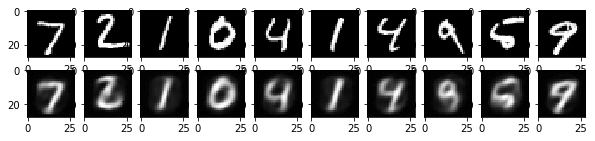

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# Parameters
learning_rate = 0.001
training_epochs = 200
batch_size = 1000
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 32*32 # 1st layer num features
#n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1,n_input])),
}    
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h1'])),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    return layer_1

def logfunc(x, x2):
    return tf.multiply( x, tf.log(tf.div(x,x2)))

def KL_Div(rho, rho_hat):
    invrho = tf.subtract(tf.constant(1.), rho)
    invrhohat = tf.subtract(tf.constant(1.), rho_hat)
    logrho = logfunc(rho,rho_hat) + logfunc(invrho, invrhohat)
    return logrho


# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
rho_hat = tf.reduce_mean(encoder_op,1)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost_m = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
cost_sparse = 0.01*tf.reduce_sum(KL_Div(0.2,rho_hat))
#cost_reg = 0.0001* (tf.nn.l2_loss(weights['decoder_h1']) + tf.nn.l2_loss(weights['encoder_h1']))
cost_reg = 0.0001*tf.nn.l2_loss(weights['encoder_h1'])
cost = tf.add(cost_reg,tf.add(cost_m,cost_sparse))

optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:10]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)),cmap='gray')
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)),cmap='gray')
    #f.show()
    #plt.draw()
    #plt.waitforbuttonpress()
    #dec = sess.run(weights['decoder_h1'])
    enc = sess.run(weights['encoder_h1'])
end_time = time.time()
print('elapsed time:',end_time - start_time)




# Plot of the Sparse feature weights learnt

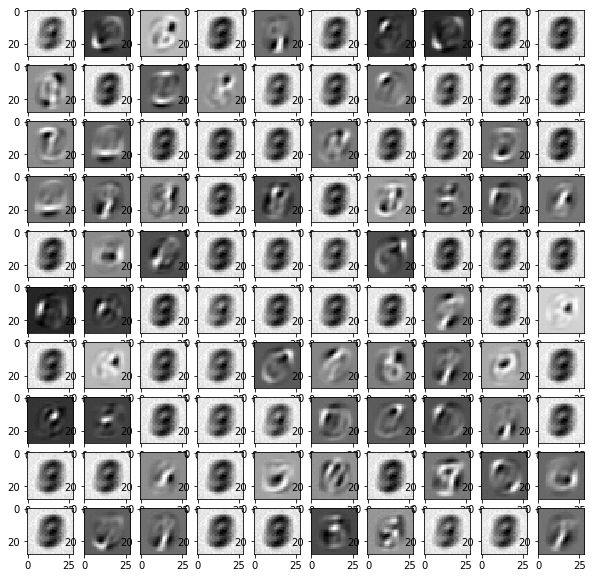

In [9]:
img_coll = []
for i in xrange(1024):
    img = np.array(enc.T[i,:])
    img = np.reshape(img,(28,28))
    img_coll.append(img)

img_coll = np.array(img_coll)
f, a = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
        a[0][i].imshow(np.reshape(img_coll[i], (28, 28)),cmap='gray')
        a[1][i].imshow(np.reshape(img_coll[10 + i], (28, 28)),cmap='gray')
        a[2][i].imshow(np.reshape(img_coll[20 + i], (28, 28)),cmap='gray')
        a[3][i].imshow(np.reshape(img_coll[30 + i], (28, 28)),cmap='gray')
        a[4][i].imshow(np.reshape(img_coll[40 + i], (28, 28)),cmap='gray')
        a[5][i].imshow(np.reshape(img_coll[50 + i], (28, 28)),cmap='gray')
        a[6][i].imshow(np.reshape(img_coll[60 + i], (28, 28)),cmap='gray')
        a[7][i].imshow(np.reshape(img_coll[70 + i], (28, 28)),cmap='gray')
        a[8][i].imshow(np.reshape(img_coll[80 + i], (28, 28)),cmap='gray')
        a[9][i].imshow(np.reshape(img_coll[90 + i], (28, 28)),cmap='gray')
        

# Listing 5-5 Denoising Auto Encoder Implementation in TensorFlow 

# Remove the Guassian Noise 

In [5]:
# Import the required library

import tensorflow.contrib.layers as lays
import numpy as np
from skimage import transform
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt 

def autoencoder(inputs):
    # encoder
    # 32 x 32 x 1   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  8 x 8 x 16
    # 8 x 8 x 16    ->  2 x 2 x 8
    net = lays.conv2d(inputs, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME')
    # decoder
    # 2 x 2 x 8    ->  8 x 8 x 16
    # 8 x 8 x 16   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  32 x 32 x 1
    net = lays.conv2d_transpose(net, 16, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d_transpose(net, 1, [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.tanh)
    return net

def resize_batch(imgs):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs

# Introduce Gaussian Noise
def noisy(image):
    row,col= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy
    

# Introduce Salt and Pepper Noise
def s_p(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.05
    out = np.copy(image)
      # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1

      # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

ae_inputs = tf.placeholder(tf.float32, (None, 32, 32, 1))  # input to the network (MNIST images)
ae_inputs_noise = tf.placeholder(tf.float32, (None, 32, 32, 1)) 
ae_outputs = autoencoder(ae_inputs_noise)  # create the Autoencoder network

# calculate the loss and optimize the network
loss = tf.reduce_mean(tf.square(ae_outputs - ae_inputs))  # claculate the mean square error loss
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# initialize the network
init = tf.global_variables_initializer()

batch_size = 500  # Number of samples in each batch
epoch_num = 5     # Number of epochs to train the network
lr = 0.001        # Learning rate

# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num):  # epochs loop
        for batch_n in range(batch_per_ep):  # batches loop
            batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
            batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
            batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
            image_arr = []
            for i in xrange(len(batch_img)):
                img = batch_img[i,:,:,0]
                img = noisy(img)
                image_arr.append(img)
            image_arr = np.array(image_arr)
            image_arr = image_arr.reshape(-1,32,32,1)
            batch_img = image_arr
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs: batch_img,ae_inputs_noise:image_arr})
            print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))

    # test the trained network
    batch_img, batch_label = mnist.test.next_batch(50)
    batch_img = resize_batch(batch_img)
    image_arr = []
    
    for i in xrange(50):
        img = batch_img[i,:,:,0]
        img = noisy(img)
        image_arr.append(img)
    image_arr = np.array(image_arr)
    image_arr = image_arr.reshape(-1,32,32,1)
    batch_img = image_arr
            
    recon_img = sess.run([ae_outputs], feed_dict={ae_inputs_noise: batch_img})[0]

    # plot the reconstructed images and their ground truths (inputs)
    plt.figure(1)
    plt.title('Reconstructed Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(recon_img[i, ..., 0], cmap='gray')
    plt.figure(2)
    plt.title('Input Images with Gaussian Noise')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(batch_img[i, ..., 0], cmap='gray')
    plt.show()

ModuleNotFoundError: No module named 'skimage'

# Remove the Salt and Pepper Noise

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1 - cost= 0.10759
Epoch: 1 - cost= 0.10432
Epoch: 1 - cost= 0.09145
Epoch: 1 - cost= 0.10456
Epoch: 1 - cost= 0.09399
Epoch: 1 - cost= 0.10294
Epoch: 1 - cost= 0.09214
Epoch: 1 - cost= 0.09225
Epoch: 1 - cost= 0.08686
Epoch: 1 - cost= 0.08006
Epoch: 1 - cost= 0.06995
Epoch: 1 - cost= 0.07494
Epoch: 1 - cost= 0.07498
Epoch: 1 - cost= 0.07392
Epoch: 1 - cost= 0.07664
Epoch: 1 - cost= 0.07144
Epoch: 1 - cost= 0.06985
Epoch: 1 - cost= 0.07153
Epoch: 1 - cost= 0.06950
Epoch: 1 - cost= 0.06736
Epoch: 1 - cost= 0.06618
Epoch: 1 - cost= 0.06272
Epoch: 1 - cost= 0.06388
Epoch: 1 - cost= 0.06702
Epoch: 1 - cost= 0.06042
Epoch: 1 - cost= 0.05949
Epoch: 1 - cost= 0.05825
Epoch: 1 - cost= 0.06138
Epoch: 1 - cost= 0.05908
Epoch: 1 - cost= 0.05936
Epoch: 1 - cost= 0.05768
Epoch: 1 - cost= 0.06140
Epoch:

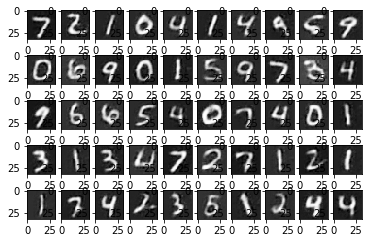

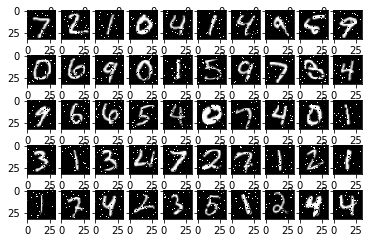

In [6]:
batch_size = 1000  # Number of samples in each batch
epoch_num = 10     # Number of epochs to train the network
lr = 0.001        # Learning rate

# read MNIST dataset
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    sess.run(init)
    for ep in range(epoch_num):  # epochs loop
        for batch_n in range(batch_per_ep):  # batches loop
            batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
            batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
            batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
            image_arr = []
            for i in xrange(len(batch_img)):
                img = batch_img[i,:,:,0]
                img = s_p(img)
                image_arr.append(img)
            image_arr = np.array(image_arr)
            image_arr = image_arr.reshape(-1,32,32,1)
            #batch_img = image_arr
            _, c = sess.run([train_op, loss], feed_dict={ae_inputs_noise:image_arr,ae_inputs: batch_img})
            print('Epoch: {} - cost= {:.5f}'.format((ep + 1), c))

    # test the trained network
    batch_img, batch_label = mnist.test.next_batch(50)
    batch_img = resize_batch(batch_img)
    image_arr = []
    
    for i in xrange(50):
        img = batch_img[i,:,:,0]
        img = s_p(img)
        image_arr.append(img)
    image_arr = np.array(image_arr)
    image_arr = image_arr.reshape(-1,32,32,1)
    #batch_img = image_arr
            
    recon_img = sess.run([ae_outputs], feed_dict={ae_inputs_noise: image_arr})[0]

    # plot the reconstructed images and their ground truths (inputs)
    plt.figure(1)
    plt.title('Reconstructed Images')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(recon_img[i, ..., 0], cmap='gray')
    plt.figure(2)
    plt.title('Input Noisy Images with Salt and Pepper Noise')
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(image_arr[i, ..., 0], cmap='gray')
    plt.show()